![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Case study -1: Hello world. Generate forcings and run Marrmot model

This notebook demostractes how to use a model in eWatercycle by showing how to run a model on a catchment and forcing data (ERA5). This notebook also contains the steps for the preprocessing of the forcing data into model specific datasets using ESMValTool.

The model used in this notebook is:

* [MARRMoT](https://github.com/wknoben/MARRMoT) M01 Collie River 1 (traditional bucket)


### Import statements
We'll be using the following modules

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import logging
logger_esmvalcore = logging.getLogger('esmvalcore')
logger_esmvalcore.setLevel(logging.WARNING)

import pandas as pd
from cartopy.io import shapereader

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.analysis
import ewatercycle.observation.grdc

### System configuration

This notebook was run on cartesius.surfsara.nl as it has a big subset of ERA5 data files, GRDC data and can run models in Singularity containers. The following configuration files are available on that cluster:

* ~/.esmvaltool/config-user.yml, tells where ESMValTool can find raw ERA5 data files and shape files
* ~/.config/ewatercycle/ewatercycle.yaml, tells ewatercycle Python package where to find GRDC data and which container image to use

More information about data, configuration and installation instructions can be found in the [System setup](https://ewatercycle.readthedocs.io/en/latest/system_setup.html) in the eWaterCycle documentation.

### Experiment settings

Discharge of the Merrimack river will be modelled for 2002.

In [6]:
dataset = "ERA5"
spinup_start_date = "2001-01-01T00:00:00Z"
spinup_end_time = "2001-12-31T00:00:00Z"
start_date = "2002-01-01T00:00:00Z"
end_date = "2002-12-31T00:00:00Z"
shapefile = "/projects/0/wtrcycle/comparison/recipes_auxiliary_datasets/Lorentz_Basin_Shapefiles/Merrimack/Merrimack.shp"

# GRDC observation station for Merrimack river
grdc_station_id = "4147380"

### Model specific settings

In [3]:
# Values based on previous calibration
maximum_soil_moisture_storage = 1999.0
initial_soil_moisture_storage = 0.9 * maximum_soil_moisture_storage

discharge_variable = "flux_out_Q"
# flux_out_Q unit conversion factor from mm/day to m3/s
conversion_mmday2m3s = 1 / (1000 * 86400)

### Pre processing model forcing using ESMValTool

In [4]:
forcing = ewatercycle.forcing.generate(
    target_model='marrmot', 
    dataset=dataset, 
    start_time=spinup_start_date,
    end_time=end_date, 
    shape=shapefile,
)

{'auxiliary_data_dir': PosixPath('/projects/0/wtrcycle/comparison/recipes_auxiliary_datasets/Lorentz_Basin_Shapefiles'),
 'compress_netcdf': False,
 'config_developer_file': None,
 'config_file': PosixPath('/home/fakhereh/.esmvaltool/config-user.yml'),
 'drs': {'CMIP5': 'default', 'CMIP6': 'default'},
 'exit_on_warning': False,
 'log_level': 'info',
 'max_parallel_tasks': 1,
 'output_dir': PosixPath('/scratch-shared/ewatercycle/case-1'),
 'output_file_type': 'png',
 'plot_dir': PosixPath('/scratch-shared/ewatercycle/case-1/recipe_marrmot_20210720_093954/plots'),
 'preproc_dir': PosixPath('/scratch-shared/ewatercycle/case-1/recipe_marrmot_20210720_093954/preproc'),
 'profile_diagnostic': False,
 'remove_preproc_dir': True,
 'rootpath': {'OBS6': [PosixPath('/lustre1/0/wtrcycle/comparison/obs6')]},
 'run_dir': PosixPath('/scratch-shared/ewatercycle/case-1/recipe_marrmot_20210720_093954/run'),
 'save_intermediary_cubes': False,
 'work_dir': PosixPath('/scratch-shared/ewatercycle/case-1/rec

Forcing is written in a single Matlab file

In [6]:
print(forcing)

eWaterCycle forcing
-------------------
start_time=2001-01-01T00:00:00Z
end_time=2002-12-31T00:00:00Z
directory=/scratch/shared/ewatercycle/case-1/recipe_marrmot_20210714_145315/work/diagnostic_daily/script
shape=/lustre1/0/wtrcycle/comparison/recipes_auxiliary_datasets/Lorentz_Basin_Shapefiles/Merrimack/Merrimack.shp
forcing_file=marrmot_ERA5_Merrimack_2001_2002.mat


### Derived constants

In [5]:
shape = shapereader.Reader(forcing.shape)
record = next(shape.records())
merrimack_area = record.attributes["SUB_AREA"] * 1e6
print("The catchment area is:", merrimack_area)

The catchment area is: 13016500000.0


### Setting up the model object

To use a hydrological model, supported by ewatercycle, an object from its class must be instantiated.

In [7]:
ewatercycle.models.MarrmotM01.available_versions

('2020.11',)

In [8]:
model = ewatercycle.models.MarrmotM01(version='2020.11', forcing=forcing)
print(model)

eWaterCycle MarrmotM01
-------------------
Version = 2020.11
Parameter set = 
  None
Forcing = 
  eWaterCycle forcing
  -------------------
  start_time=2001-01-01T00:00:00Z
  end_time=2002-12-31T00:00:00Z
  directory=/scratch/shared/ewatercycle/case-1/recipe_marrmot_20210720_093954/work/diagnostic_daily/script
  shape=/lustre1/0/wtrcycle/comparison/recipes_auxiliary_datasets/Lorentz_Basin_Shapefiles/Merrimack/Merrimack.shp
  forcing_file=marrmot_ERA5_Merrimack_2001_2002.mat


Create config file and start up container for Marrmot

In [9]:
cfg_file, cfg_dir = model.setup(
    # No need to specifiy start and end date, using dates from forcing
    maximum_soil_moisture_storage=maximum_soil_moisture_storage,
    initial_soil_moisture_storage=initial_soil_moisture_storage,
)
print(cfg_file)
print(cfg_dir)

Running /scratch/shared/ewatercycle/case-1/ewatercycle-marrmot-grpc4bmi_2020.11.sif singularity container on port 43096
/scratch/shared/ewatercycle/case-1/marrmot_20210720_094311/marrmot-m01_config.mat
/scratch/shared/ewatercycle/case-1/marrmot_20210720_094311


In [10]:
model.initialize(cfg_file)

Spin up for a year

In [11]:
while (model.time_as_isostr < spinup_end_time):
    model.update()

### Run model & capture discharge

In [12]:
simulated_discharge = []
timestamps = []
end_time = model.end_time

while (model.time < end_time):
    model.update()
    timestamps.append(model.time_as_datetime.date())
    # Marrmot M01 is a lumped model, so only single value is returned
    value_in_mmday = model.get_value(discharge_variable)[0]
    # Convert from mm/day to m3/s
    value = value_in_mmday * merrimack_area * conversion_mmday2m3s
    simulated_discharge.append(value)

The `timestamps` and `simulated_discharge` variables are now filled with datetime values and discharges for each simulated day.

### Clean up after the model run
The models have to be 'finalized', which deletes any temporary files and the containers have to be shut down.

In [13]:
model.finalize()

### Import GRDC observations

Read the GRDC data for the period of the experiment, for the station given above. 
If you are not on jupyter.ewatercycle.org or Cartesius, download the GRDC https://www.bafg.de/GRDC/EN/02_srvcs/21_tmsrs/riverdischarge_node.html and set the `grdc_location` field in `~/.config/.ewatercycle/ewatercycle.yaml` to your download location.

In [14]:
observations, metadata = ewatercycle.observation.grdc.get_grdc_data(
    station_id=grdc_station_id,
    start_time=start_date,
    end_time=end_date,
)
observations

GRDC station 4147380 is selected. The river name is: MERRIMACK RIVER.The coordinates are: (42.6459, -71.2984).The catchment area in km2 is: 12004.7. There are 0 missing values during 2002-01-01T00:00:00Z_2002-12-31T00:00:00Z at this station. See the metadata for more information.


,streamflow
time,
2002-01-01,56.067
2002-01-02,54.085
2002-01-03,48.988
2002-01-04,50.121
2002-01-05,47.572
...,...
2002-12-27,222.853
2002-12-28,228.800
2002-12-29,218.039


### Plot the results

Combine simulated and observated discharge into a single dataframe

In [15]:
simulated_discharge_df = pd.DataFrame(
    {'simulation': simulated_discharge}, index=pd.to_datetime(timestamps)
)
observations_df = observations.rename(
    columns={'streamflow': 'observation'}
)
discharge = simulated_discharge_df.join(observations_df)
discharge

,simulation,observation
2002-01-01,0.060043,56.067
2002-01-02,0.072991,54.085
2002-01-03,0.028182,48.988
2002-01-04,0.050347,50.121
2002-01-05,0.002331,47.572
...,...,...
2002-12-27,2153.037396,222.853
2002-12-28,1.905574,228.800
2002-12-29,0.319505,218.039
2002-12-30,7.983492,203.031


(<Figure size 720x720 with 2 Axes>,
 (<AxesSubplot:title={'center':'Hydrograph'}, ylabel='Discharge (m$^3$ s$^{-1}$)'>,
  <AxesSubplot:>))

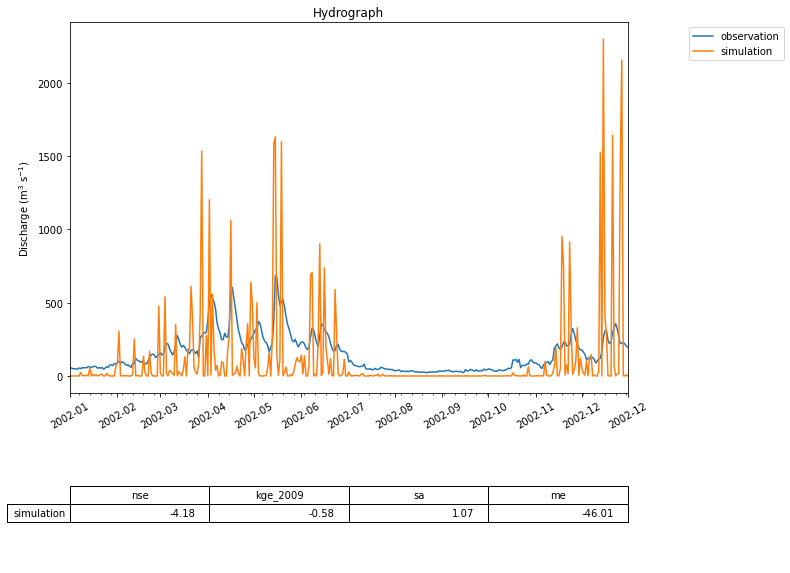

In [16]:
ewatercycle.analysis.hydrograph(
    discharge=discharge,
    reference='observation',
)